# Fine-Tuning BERT for text classification with LoRA

## [2024.05.01] 이상혁

## Introduction

Fine-tuning a Large Language Model (LLM) is definitely challenging, as it involves updating trillions of parameters. Recently, various research papers have presented different techniques to fine-tune LLMs more quickly and with reduced computational demands. **LoRA (Low-Rank Adaptation)** is one such solution that utilizes matrix decomposition to efficiently fine-tune LLMs.

Here's the brief information how LoRA works.

To fine-tune pre-trained LLMs, it is essential to modify every single weight in each layer. Instead, LoRA introduces a method to learn a lower-dimensional, task-specific representation of the layer's weights.

Consider a fully connected layer with $m$ input units and $n$ output units. Then the weight matrix for this fully connected layer has $m \times n$. If we provide an input $x$, the output layer is calculated by $Y = W X$.

During fine-tuning with LoRA, this $A$ matrix breaks down into two parts. One is $A$ and the other is $B$. The new equation becomes $Y = W X + A*B X$.

Consider the below case.

$$ m=800, n=3200$$

Then the dimension of the $W$ matrix is $800*3200=2560000$.

And here comes the innovation of LoRA. New matrix $A$, $B$ is shown as below.

$$ A = 800 \times r, B = r \times 3200 $$

Now we can adjust the value of $r$, and if we set $r$ to 1, the number of weights in this layer becomes as below.

$$ (800 \times 1) + (1 \times 3200) = 4000 $$

As we can see, this is a significant reduction compared to fine-tuning with $2560000$ weights.

Consequently, fine-tuning an LLM becomes much faster and requires considerably less computational power, thanks to LoRA 🤩

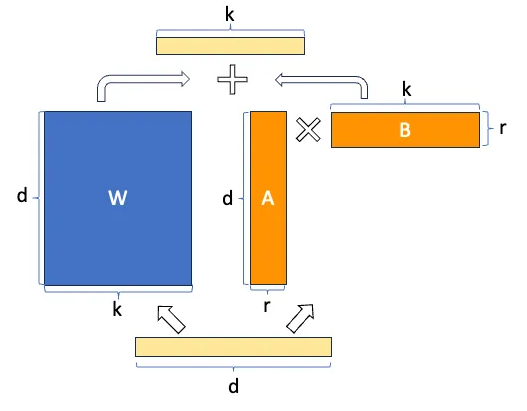


I will try binary classification with BERT using LoRA.

Reference : [Fine-Tuning BERT for text classification with LoRA](https://medium.com/@karkar.nizar/fine-tuning-bert-for-text-classification-with-lora-f12af7fa95e4)

## Getting Start!

### 1. Installing dependencies

In [2]:
!pip install transformers
!pip install peft
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

### 2. Downloading the dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### 3. Text Pre-processing
- Tokenize the sequence with BERT tokenizer

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### 4. Create Smaller Dataset
- Create a smaller dataset for fine tuning to save time

In [7]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

### 5. Injecting LoRA to the BERT model
- The primary objective of fine-tuning the BERT model is to perform binary classification, hence the ```TaskType.SEQ_CLS``` (Sequence Classification) setting was selected.  This configuration explicitly tailors the model to classify sequences, aligning its architecture and training focus with the requirements of binary classification tasks.

In [10]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type = TaskType.SEQ_CLS, # Specify the task type for which the model will undergo fine-tuning
    r = 1, # Dimension of the decomposed A, B matrix
    lora_alpha = 1, # Determining the relative significance of the weights in A, B matrix
    lora_dropout = 0.1 # Dropout rate for preventing overfitting
)

### 6. Define BERT Model for Classisfication

In [28]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 7. Fitting BERT into Classification by LoRA
- Insert the A and B matrices into our model by invoking the ```get_peft_model``` function.

In [29]:
from peft import get_peft_model
model = get_peft_model(model, lora_config)

### 8. Check the Trainable Parameters

In [30]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable(%): {100 * trainable_params / all_param}"
    )

In [40]:
print_trainable_parameters(model)

trainable params: 38402 || all params: 108350212 || trainable%: 0.03544247795288116


Only 0.03% of the parameters are updated during the fine-tuning process. This efficiency in parameter optimization is remarkable.

### 9. Start Training

In [32]:
import numpy as np
import evaluate

# Use Accuracy Metric from hugging face
metric = evaluate.load("accuracy")

In [33]:
# Accuracy of the predictions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [34]:
# Create a TrainingArguments class
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=25)

In [37]:
# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

- No need to specify cuda, as ```no_cuda=False``` is default in hugging face ```Trainer```

In [36]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.701402,0.456000
2,No log,0.689571,0.555000
3,No log,0.687936,0.523000
4,0.703300,0.685065,0.524000
5,0.703300,0.668726,0.626000
6,0.703300,0.656057,0.661000
7,0.703300,0.634244,0.670000
8,0.669300,0.601633,0.694000
9,0.669300,0.565763,0.722000
10,0.669300,0.529476,0.744000


TrainOutput(global_step=3125, training_loss=0.5090345422363282, metrics={'train_runtime': 2656.2549, 'train_samples_per_second': 9.412, 'train_steps_per_second': 1.176, 'total_flos': 6580725657600000.0, 'train_loss': 0.5090345422363282, 'epoch': 25.0})

The accuracy increased to 83% over the course of 25 epochs.

### 10. Compare with Full Fine-tuning Model

In [45]:
BertModel = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
print_trainable_parameters(BertModel)

trainable params: 108311810 || all params: 108311810 || trainable%: 100.0


In [47]:
training_args = TrainingArguments(output_dir="test_trainer_full", evaluation_strategy="epoch", num_train_epochs=5)

In [48]:
trainer = Trainer(
    model=BertModel,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.484356,0.848000
2,No log,0.568350,0.860000
3,No log,0.598446,0.867000
4,0.280100,0.717024,0.856000
5,0.280100,0.784943,0.860000


TrainOutput(global_step=625, training_loss=0.22879168243408204, metrics={'train_runtime': 645.1158, 'train_samples_per_second': 7.751, 'train_steps_per_second': 0.969, 'total_flos': 1315555276800000.0, 'train_loss': 0.22879168243408204, 'epoch': 5.0})

In the case of the full **fine-tuned BERT** model, where 100% of the parameters were updated, the accuracy reached 86% within just 5 epochs.

## Conclusion

Despite updating only 0.03% of the parameters, the performance difference compared to a model with full fine-tuning is minimal. Utilizing LoRA allows for the fine-tuning of Large Language Models (LLMs) on moderate GPUs, enabling the execution of numerous tasks.